# ITMO ML Lab1. Kernel regression.

In [1]:
import pandas as pd

## Data preprocessing

In [2]:
data = pd.read_csv("../data/phpPrh7lv.csv")

In [3]:
data

,V1,V2,V3,V4,V5,V6,V7,Class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


In [4]:
data = data.dropna()

In [5]:
data

,V1,V2,V3,V4,V5,V6,V7,Class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


In [6]:
y = data.Class

In [7]:
y

0      1
1      1
2      1
3      1
4      1
      ..
205    3
206    3
207    3
208    3
209    3
Name: Class, Length: 210, dtype: int64

In [8]:
X = data.drop(columns=['Class'])
X

,V1,V2,V3,V4,V5,V6,V7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175
...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044


In [9]:
X.dtypes

V1    float64
V2    float64
V3    float64
V4    float64
V5    float64
V6    float64
V7    float64
dtype: object

## Normalizing

In [10]:
def minmax(data):
    value_min = min(data)
    value_max = max(data)
    return value_min, value_max


def normalize(series):
    data = list(series)
    v_min, v_max = minmax(data)
    delta = v_max - v_min
    for i in range(len(data)):
        data[i] = (data[i] - v_min) / delta
    return pd.Series(data)

In [11]:
X.V1 = normalize(data.V1)
X.V2 = normalize(data.V2)
X.V3 = normalize(data.V3)
X.V4 = normalize(data.V4)
X.V5 = normalize(data.V5)
X.V6 = normalize(data.V6)
X.V7 = normalize(data.V7)

In [12]:
X.head()

,V1,V2,V3,V4,V5,V6,V7
0,0.440982,0.502066,0.570780,0.486486,0.486101,0.189302,0.345150
1,0.405099,0.446281,0.662432,0.368806,0.501069,0.032883,0.215165
2,0.349386,0.347107,0.879310,0.220721,0.503920,0.251453,0.150665
3,0.306893,0.316116,0.793103,0.239302,0.533856,0.194243,0.140817
4,0.524079,0.533058,0.864791,0.427365,0.664291,0.076701,0.322994


## Hyperparameter optimization

In [13]:
import sys
sys.path.append('../../../cf')
from uniform_split_A import uniform_split
from kernel_regression_C import KNNRegression, distance_names, kernel_names, window_names
from f1_score_B import compute_f1_score

In [14]:
def one_out_cv(X, y, class_recognizer, classes_count, params, target_count=1):
    y_test = []
    y_predicted = []
    for i in range(len(X)):
        X_copy = X.copy()
        y_copy = y.copy()
        x_test = X_copy.pop(i)
        y_test.append(class_recognizer(y_copy.pop(i)))
        classifier = KNNRegression(*params)
        classifier.fit(X_copy, y_copy)
        y_predicted.append(class_recognizer(classifier.predict(x_test, target_count)))
    return get_confusion_matrix(y_test, y_predicted, classes_count)

def get_confusion_matrix(y_test, y_predicted, classes_count):
    confusion_matrix = [[0 for _ in range(classes_count)] for _ in range(classes_count)]
    for test, pred in zip(y_test, y_predicted):
        confusion_matrix[test - 1][pred - 1] += 1
    return confusion_matrix

def hyperparameter_optimization(X, y, classes_count, class_recognizer, target_count=1, curr_window_names=window_names):
    best_f1_score = 0
    for distance_name in distance_names:
        for kernel_name in kernel_names:
            for window_name in curr_window_names:
                for h in range(1, 40):
                    params = [distance_name, kernel_name, window_name, h]
                    confusion_matrix = one_out_cv(X, y, class_recognizer, classes_count, params, target_count)
                    f1_score = compute_f1_score(confusion_matrix, 'macro')
                    if best_f1_score < f1_score:
                        best_f1_score = f1_score
                        best_params = params
                        print("Finished with best params", best_params, f1_score)
    print('Overall best params:', best_params)
    print('Overall best macro f1-score:', best_f1_score)
    return best_params, best_f1_score

## Naive representation of target feature

In [15]:
y

0      1
1      1
2      1
3      1
4      1
      ..
205    3
206    3
207    3
208    3
209    3
Name: Class, Length: 210, dtype: int64

In [16]:
X

,V1,V2,V3,V4,V5,V6,V7
0,0.440982,0.502066,0.570780,0.486486,0.486101,0.189302,0.345150
1,0.405099,0.446281,0.662432,0.368806,0.501069,0.032883,0.215165
2,0.349386,0.347107,0.879310,0.220721,0.503920,0.251453,0.150665
3,0.306893,0.316116,0.793103,0.239302,0.533856,0.194243,0.140817
4,0.524079,0.533058,0.864791,0.427365,0.664291,0.076701,0.322994
...,...,...,...,...,...,...,...
205,0.151086,0.163223,0.637024,0.134009,0.250178,0.372635,0.172821
206,0.060434,0.097107,0.390200,0.135698,0.117605,0.462872,0.238306
207,0.246459,0.258264,0.727768,0.189752,0.429081,0.981667,0.264402
208,0.118036,0.165289,0.399274,0.155405,0.146828,0.368344,0.258493


In [17]:
X = X.values.tolist()
y = list([i] for i in y)

In [18]:
import math

In [19]:
hyperparameter_optimization(X, y, 3, lambda x: round(x[0]))

Finished with best params ['manhattan', 'uniform', 'fixed', 1] 0.8052078807217543
Finished with best params ['manhattan', 'uniform', 'variable', 1] 0.933298881116285
Finished with best params ['euclidean', 'uniform', 'variable', 1] 0.9431632107325978
Overall best params: ['euclidean', 'uniform', 'variable', 1]
Overall best macro f1-score: 0.9431632107325978


(['euclidean', 'uniform', 'variable', 1], 0.9431632107325978)

## One-hot representation

In [20]:
import numpy as np

In [21]:
y = [i[0] for i in y]
y = pd.DataFrame({'target': y})
y

,target
0,1
1,1
2,1
3,1
4,1
...,...
205,3
206,3
207,3
208,3


In [22]:
y['target0'] = pd.Series(y.target == 1)
y['target1'] = pd.Series(y.target == 2)
y['target2'] = pd.Series(y.target == 3)
y = y.drop(columns = ['target'])
y = y.astype({'target0': 'int32', 'target1': 'int32', 'target2': 'int32'})

In [23]:
y = y.values.tolist()

In [24]:
hyperparameter_optimization(X, y, 3, lambda x: np.asarray(x).argmax() + 1, 3)

Finished with best params ['manhattan', 'uniform', 'fixed', 1] 0.9145528909117744
Finished with best params ['manhattan', 'uniform', 'variable', 1] 0.933298881116285
Finished with best params ['manhattan', 'triangular', 'variable', 10] 0.9332995191572654
Finished with best params ['manhattan', 'quartic', 'variable', 3] 0.9381021699782677
Finished with best params ['euclidean', 'uniform', 'variable', 1] 0.9431632107325978
Finished with best params ['euclidean', 'uniform', 'variable', 4] 0.9524805735653242
Overall best params: ['euclidean', 'uniform', 'variable', 4]
Overall best macro f1-score: 0.9524805735653242


(['euclidean', 'uniform', 'variable', 4], 0.9524805735653242)

## Analyzing best model

In [25]:
import seaborn as sns

In [26]:
def plot(neighbours_count, f1_score, metrics_name):
    neighbours_count = pd.Series(neighbours_count)
    f1_score = pd.Series(f1_score)
    plot_data = pd.DataFrame({"neighbours_count": neighbours_count, metrics_name: f1_score})
    sns.lineplot(data=plot_data, x="neighbours_count", y=metrics_name)

### Variable window size

In [27]:
macro_f1_scores = []
micro_f1_scores = []
matrices = []
class_recognizer = lambda x: np.asarray(x).argmax() + 1
for h in range(1, 50):
    params = ['euclidean', 'uniform', 'variable', h]
    confusion_matrix = one_out_cv(X, y, class_recognizer, 3, params, 3)
    matrices.append(confusion_matrix)
    macro_f1_score = compute_f1_score(confusion_matrix, 'macro')
    macro_f1_scores.append(macro_f1_score)

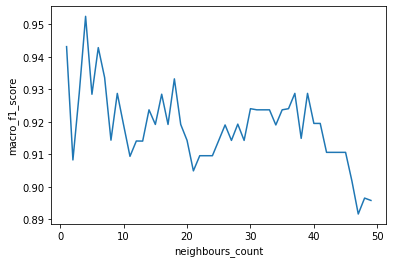

In [28]:
plot([h for h in range(1, 50)], macro_f1_scores, 'macro_f1_score')

### Fixed window size

In [29]:
hyperparameter_optimization(X, y, 3, lambda x: np.asarray(x).argmax() + 1, 3, curr_window_names=['fixed'])

Finished with best params ['manhattan', 'uniform', 'fixed', 1] 0.9145528909117744
Finished with best params ['manhattan', 'triangular', 'fixed', 1] 0.9241444296446556
Finished with best params ['manhattan', 'triweight', 'fixed', 1] 0.9286571742596913
Overall best params: ['manhattan', 'triweight', 'fixed', 1]
Overall best macro f1-score: 0.9286571742596913


(['manhattan', 'triweight', 'fixed', 1], 0.9286571742596913)

In [30]:
macro_f1_scores = []
matrices = []
class_recognizer = lambda x: np.asarray(x).argmax() + 1
for h in range(1, 50):
    params = ['manhattan', 'triweight', 'fixed', h]
    confusion_matrix = one_out_cv(X, y, class_recognizer, 3, params, 3)
    matrices.append(confusion_matrix)
    macro_f1_score = compute_f1_score(confusion_matrix, 'macro')
    macro_f1_scores.append(macro_f1_score)

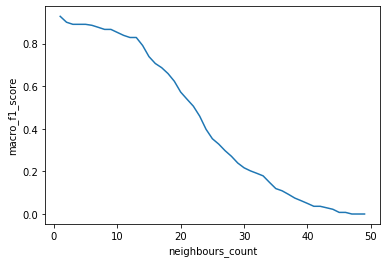

In [31]:
plot([h for h in range(1, 50)], macro_f1_scores, 'macro_f1_score')